# Binary Classification with JAX and Keras

In this notebook you should recreate the logstic regression from the first notebook but this time use the autodiff framework of JAX and keras

In [2]:
import platform
import subprocess
import os
from datetime import datetime

# --- JAX ---
import jax
import jax.numpy as jnp

# --- NumPy ---
import numpy as np

# --- PyTorch ---
import torch

# --- Keras 3 ---
os.environ["KERAS_BACKEND"] = "torch"   # or "jax", depending on usage
import keras

print("=== Python & OS Info ===")
print("Date: {}".format(datetime.now()))
print(f"Python version:      {platform.python_version()}")
print(f"System:              {platform.system()}")
print(f"Machine:             {platform.machine()}")             # arm64 on Apple Silicon
print(f"Processor:           {platform.processor()}")
print(f"Mac version:         {platform.mac_ver()[0]}")           # macOS version
print()
# Optionally: Detect Apple chip
def get_chip_info():
    try:
        out = subprocess.check_output(
            ["sysctl", "-n", "machdep.cpu.brand_string"]
        ).decode().strip()
        return out
    except Exception:
        return "unknown"

print(f"Chip:          {get_chip_info()}")
print()

print("=== JAX Info ===")
print(f"JAX version:         {jax.__version__}")
print(f"JAX devices:         {jax.devices()}")
print()

print("=== PyTorch Info ===")
print(f"PyTorch version:     {torch.__version__}")
print(f"CUDA available:      {torch.cuda.is_available()}")
print(f"Device:              {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print()

print("=== NumPy & Keras ===")
print(f"NumPy version:       {np.__version__}")
print(f"Keras version:       {keras.__version__}")
print(f"Keras backend:       {keras.config.backend()}")

=== Python & OS Info ===
Date: 2025-11-26 14:14:50.564806
Python version:      3.10.10
System:              Darwin
Machine:             arm64
Processor:           arm
Mac version:         15.5

Chip:          Apple M2 Pro

=== JAX Info ===
JAX version:         0.6.2
JAX devices:         [METAL(id=0)]

=== PyTorch Info ===
PyTorch version:     2.9.1
CUDA available:      False
Device:              cpu

=== NumPy & Keras ===
NumPy version:       2.2.6
Keras version:       3.12.0
Keras backend:       torch


### Generate training data

In [3]:
import numpy as np

def generate_training_data(ntrain=200, scale=6.0, seed=None):
    """
    Reproduce the training data (x2, y0) from 01_mlp.ipynb.

    - 2D inputs start uniform on [0, scale]^2
    - Then mapped into four quadrants
    - Labels: quadrants I & III -> 1, quadrants II & IV -> 0
    - Final features x2 are sigmoid-transformed coordinates (perzeptron with w = I, b = 0)
    """
    rng = np.random.default_rng(seed)

    # 2d-Inputs (this is x0 in the notebook)
    x0 = rng.random((ntrain, 2))
    x0 *= scale

    # Quadrant manipulation exactly as in the notebook
    q = ntrain // 4

    # indices [q : 2q): flip x -> quadrant II
    x0[q:2*q, 0] *= -1.0

    # indices [2q : 3q): flip y -> quadrant IV
    x0[2*q:3*q, 1] *= -1.0

    # indices [3q : ntrain): flip both -> quadrant III
    x0[3*q:, :] *= -1.0

    # labels (y0 in the notebook)
    y0 = np.ones(ntrain, dtype=float)
    y0[q:2*q] = 0.0        # quadrant II
    y0[2*q:3*q] = 0.0      # quadrant IV
    # first q and last q remain 1.0 (quadrants I & III)

    # Perzeptron transform with w = I, b = 0 -> this is x2 in the notebook
    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    x2 = sigmoid(x0)

    return x2, y0

# In the first notebook a scale of 6.0 was used, here we use 1.0
x2, y0 = generate_training_data(ntrain=200, scale=1.0, seed=42) 

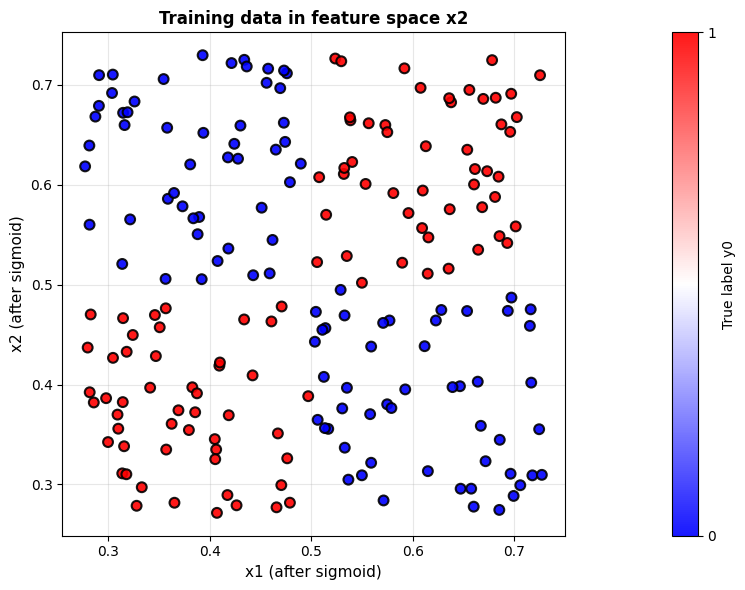

In [2]:
import matplotlib.pyplot as plt

def plot_data_and_probability(x, y, params=None, predict_proba_func=None, figsize=(8, 6)):
    """
    Plot training data and optionally forecasted probability.
    
    Parameters:
    -----------
    x : array-like, shape (n_samples, 2)
        Training data features
    y : array-like, shape (n_samples,)
        Training data labels (0 or 1)
    params : dict, optional
        Model parameters. If None, only data is plotted.
    predict_proba_func : callable, optional
        Function to predict probabilities: predict_proba_func(params, x)
        Required if params is not None.
    figsize : tuple, optional
        Figure size (default: (8, 6))
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Create a grid for probability contours (if model is provided)
    if params is not None and predict_proba_func is not None:
        x1_min, x1_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
        x2_min, x2_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                               np.linspace(x2_min, x2_max, 100))
        grid_points = np.c_[xx1.ravel(), xx2.ravel()]

        # Predict probabilities on the grid
        proba_grid = predict_proba_func(params, grid_points)
        proba_grid = np.array(proba_grid).reshape(xx1.shape)

        # Plot probability contours (reversed colormap: red = high prob for class 1)
        contour = ax.contourf(xx1, xx2, proba_grid, levels=20, cmap='RdYlBu_r', alpha=0.6)
        cbar1 = plt.colorbar(contour, ax=ax)
        cbar1.set_label('Forecasted probability p(y=1|x)', fontsize=10)

        # Add decision boundary (p=0.5)
        contour_lines = ax.contour(xx1, xx2, proba_grid, levels=[0.5], colors='black', 
                                   linewidths=2, linestyles='--', zorder=5)
        ax.clabel(contour_lines, inline=True, fontsize=10, fmt='p=0.5')
        
        title = 'Training Data and Forecasted Probability'
    else:
        title = 'Training data in feature space x2'

    # Plot training data points
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', 
                         edgecolor='k', linewidth=1.5, s=50, alpha=0.9, zorder=10)
    cbar2 = plt.colorbar(scatter, ax=ax, ticks=[0, 1], pad=0.15)
    cbar2.set_label('True label y0', fontsize=10)

    ax.set_xlabel('x1 (after sigmoid)', fontsize=11)
    ax.set_ylabel('x2 (after sigmoid)', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the training data
plot_data_and_probability(x2, y0)

# Start of your code

## a) Logistic Regression with JAX

Please implement the logistic regression model and the negative log-likelihood loss function using JAX. Think of jax as a numpy replacement, with autodifferentiation. You can use the following code as a starting point.

In [ ]:
# ------------------------------------------------------------
# Parameter initialization (fully implemented)
# ------------------------------------------------------------
def init_params(seed=0):
    """
    Initialize parameters for logistic regression.

    Returns a dictionary:
        params = {
            "w": w,   # shape (2,)
            "b": b    # scalar
        }
    """
    key = jax.random.PRNGKey(seed)
    # Random initialization for weights (small values)
    w = 0.1 * jax.random.normal(key, (2,))
    # Bias initialized to zero
    b = jnp.array(0.0)
    return {"w": w, "b": b}


# ------------------------------------------------------------
# Model: p(y = 1 | x) given the parameters
# ------------------------------------------------------------
def predict_proba(params, x):
    """
    Compute p(y = 1 | x).

    TODO:
      - Return probability p for class 1
    """
    w = params["w"]
    b = params["b"]
    # return p
    raise NotImplementedError("predict_proba() is not implemented yet.")


# ------------------------------------------------------------
# Negative Log-Likelihood loss
# ------------------------------------------------------------
def nll_loss(params, x, y):
    """
    Binary cross-entropy / negative log-likelihood.

    TODO:
      - Return negative mean of the negative log-likelihood
    """
    raise NotImplementedError("nll_loss() is not implemented yet.")


# ------------------------------------------------------------
# Full-batch gradient descent training loop
# ------------------------------------------------------------
def train(x, y, lr=0.5, n_steps=2000):
    """
    Full-batch gradient descent training.

    TODO:
      - Initialize params = init_params()
      - Define grad_loss = jax.grad(nll_loss)
      - Loop over steps:
          * compute gradients
          * update w and b
      - Print loss every 200 steps (optional)
      - Return final params
    """
    params = init_params()
    grad_loss = jax.grad(nll_loss)
    for step in range(n_steps):
        grads = grad_loss(params, x, y)
    raise NotImplementedError("train() is not implemented yet.")


# ------------------------------------------------------------
# After students implement everything:
# params = train(x2, y0)
# ------------------------------------------------------------
# Plot the data and forecasted probability
# plot_data_and_probability(x2, y0, params, predict_proba)

## b) Make multi-layer perceptron
Add a hidden layer of dimension 16 to the model and redo a). To improve the performance, use jit by putting the update step in a jit function.
```python
@jax.jit
def update(params, x, y, lr):
    grads = jax.grad(nll_loss)(params, x, y)
    return {
        "W1": params["W1"] - lr * grads["W1"],
        # YOUR CODE HERE
        }
```

## c) Implement the MLP in Keras 

Implement the MLP in Keras using the sequential API. 